In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm
from lr.text_processing.util import pre_process_nli_df, get_vocab_count
from lr.text_processing.transformations.util import syn_h2tranformation, syn_p2tranformation
from lr.text_processing.transformations.util import syn2tranformation
from lr.text_processing.transformations.util import get_augmented_data
from lr.text_processing.transformations.structural import invert, entailment_internalization
from lr.training.util import get_binary_label, get_ternary_label
from lr.training.language_representation import Tfidf
from lr.training.util import filter_df_by_label
from lr.models.logistic_regression import LRWrapper
from lr.stats.matched_comparison import get_disagreement_statistics
from IPython.display import HTML, display

# load data

In [2]:
train_path = "data/snli/train.csv"
dev_path = "data/snli/dev.csv"
debug = False

df = pd.read_csv(train_path)
dev = pd.read_csv(dev_path)

if debug:
    df = df.head(1000)
    dev = dev.head(1000)

df = filter_df_by_label(df.dropna()).reset_index(drop=True)
dev = filter_df_by_label(dev.dropna()).reset_index(drop=True)

pre_process_nli_df(df)
pre_process_nli_df(dev)

## Creating lexical masking

In [3]:
head = 800
mwords = 300

c = get_vocab_count(df.head(head))
mask = {i[0]: "" for i in c.most_common(mwords)}

# get pct x t

In [4]:
trials = 50
max_features = 1000

label_translation = get_ternary_label
# label_translation = get_binary_label

# transformation = syn2tranformation(mask)
transformation = syn_h2tranformation(mask)
# transformation = invert
# transformation = entailment_internalization
# transformation = syn_p2tranformation(mask)

dev_t = get_augmented_data(df=dev,
                           transformation=transformation,
                           frac=1)


pcts = np.linspace(0, 1, trials)
stats = []



hyperparams = {"RepresentationFunction": Tfidf,
               "max_features": max_features,
               "label_translation": label_translation,
               "penalty": "l2",
               "C": 1,
               'solver': 'lbfgs'}

for pct in tqdm(pcts):

    aug = get_augmented_data(df=df,
                             transformation=transformation,
                             frac=pct)

    lr = LRWrapper(hyperparams)
    lr.fit(aug)


    st = get_disagreement_statistics(df=dev,
                                     df_t=dev_t,
                                     model=lr,
                                     label_translation=label_translation)

    stats.append(st)
    del lr, aug
    
result = pd.concat(stats)
result.index = pcts
result.index.name = "pcts"

  0%|          | 0/50 [00:00<?, ?it/s]/home/felsal/lr/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
  2%|▏         | 1/50 [00:27<22:29, 27.54s/it]/home/felsal/lr/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solv

## Plots

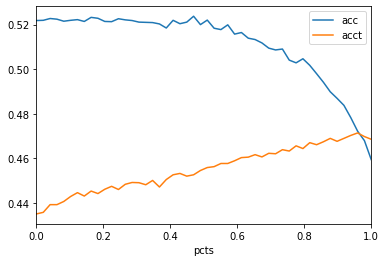

In [5]:
result[["acc", 'acct']].plot();

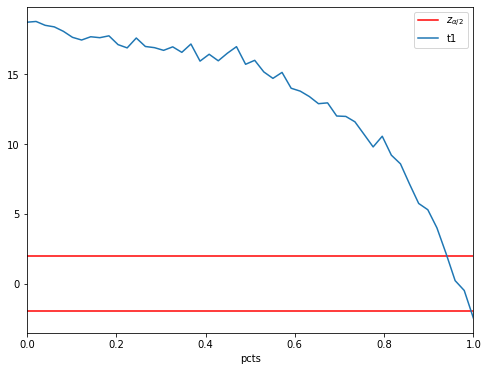

In [6]:
alpha = 0.05
z_alpha_2 =  scipy.stats.norm.ppf(1  - (alpha/2))
paired_t_reject_H0 = result.t1.apply(np.abs) > z_alpha_2
paired_t_reject_H0 = paired_t_reject_H0.apply(lambda x: "reject H0" if x else "retain  H0")
paired_t_reject_H0.name = "paired_t"

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=z_alpha_2, color='r', linestyle='-', label=r"$z_{\alpha/2}$")
plt.axhline(y=-z_alpha_2, color='r', linestyle='-')
result[["t1"]].plot(ax=ax);
plt.legend(loc="best");

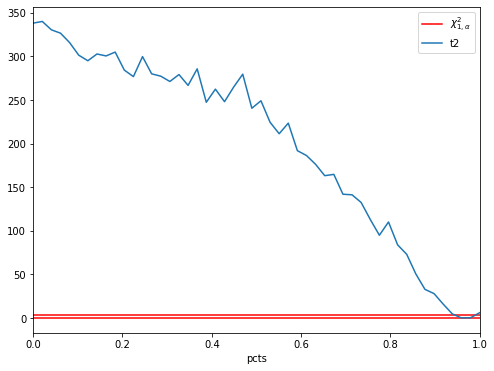

In [7]:
chi_2_alpha =  scipy.stats.chi2.ppf(1 - alpha, df=1)
cochran_reject_H0 = result.t2 > chi_2_alpha
cochran_reject_H0 = cochran_reject_H0.apply(lambda x: "reject H0" if x else "retain  H0")
cochran_reject_H0.name = "cochran"

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=chi_2_alpha, color='r', linestyle='-', label=r"$\chi^{2}_{1,\alpha}$")
plt.axhline(y=0, color='r', linestyle='-')
result[["t2"]].plot(ax=ax);
plt.legend(loc="best");

## Tests
### basic info

In [8]:
tests = pd.DataFrame([paired_t_reject_H0, cochran_reject_H0]).transpose()
disagreement = tests[~ (tests.cochran == tests.paired_t)]
display(HTML(tests.cochran.value_counts().to_frame().to_html()))
display(HTML(tests.paired_t.value_counts().to_frame().to_html()))
display(HTML(disagreement.to_html()))

,cochran
reject H0,48
retain H0,2


,paired_t
reject H0,48
retain H0,2


,paired_t,cochran
pcts,,


### p-values

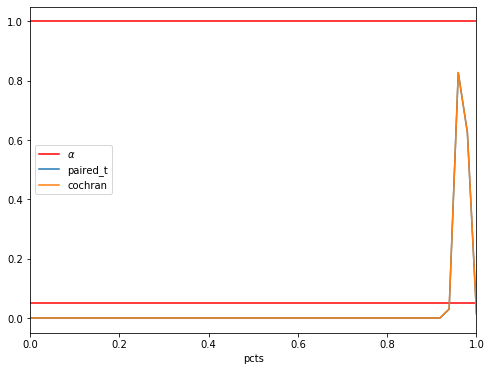

In [9]:
p_normal = lambda x: 2*scipy.stats.norm.cdf(- np.abs(x))
p_chi2 = lambda x: 1 - scipy.stats.chi2.cdf(x,df=1)
p_t1 = result.t1.map(p_normal)
p_t1.name = "paired_t"
p_t2 = result.t2.map(p_chi2)
p_t2.name = "cochran"
p_values = pd.DataFrame([p_t1, p_t2]).transpose()

fig, ax = plt.subplots(1,1,figsize=(8,6))
plt.axhline(y=1, color='r', linestyle='-')
plt.axhline(y=alpha, color='r', linestyle='-', label=r"$\alpha$")
p_values.plot(ax=ax);
plt.legend(loc="best");